## Tensorflow Basics

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

##### difference between np and tf

different from np, tf returns a array object without any number yet

In [2]:
## numpy 
x = np.linspace(-3.0, 3.0, 10)
print('np array: ',x)
## tf
x = tf.linspace(-3.0, 3.0, 10)
print('tf array: ',x)

np array:  [-3.         -2.33333333 -1.66666667 -1.         -0.33333333  0.33333333
  1.          1.66666667  2.33333333  3.        ]
tf array:  Tensor("LinSpace:0", shape=(10,), dtype=float32)


whenever you create a tensor object, it will be automatically add to the default tensor graph. if you run previous code twice, it will add two tensor to the graph. you can also take a look at tensor graph. 

In [3]:
## load a default graph 
g = tf.get_default_graph()
print([op.name for op in g.get_operations()])

['LinSpace/start', 'LinSpace/stop', 'LinSpace/num', 'LinSpace']


##### Session

In [4]:
# We're first going to create a session:
sess = tf.Session()   ## by default, graph = g. you can also point it to a different graph

# Now we tell our session to compute anything we've created in the tensorflow graph.
computed_x = sess.run(x)
print(computed_x)

# Alternatively, we could tell the previous Tensor to evaluate itself using this session:
computed_x = x.eval(session=sess)
print(computed_x)

# We can close the session after we're done like so:
sess.close()

[-3.         -2.33333325 -1.66666663 -1.         -0.33333325  0.33333349
  1.          1.66666698  2.33333349  3.        ]
[-3.         -2.33333325 -1.66666663 -1.         -0.33333325  0.33333349
  1.          1.66666698  2.33333349  3.        ]


We can also use a interactivce session. so that we can run things interactively

In [5]:
## start an interactively session 
sess = tf.InteractiveSession()    ## we will leave it open for now

print(x.eval())   ## .eval returns a np array
print(x.get_shape())

[-3.         -2.33333325 -1.66666663 -1.         -0.33333325  0.33333349
  1.          1.66666698  2.33333349  3.        ]
(10,)


#### Now let's make a Gaussian curve

In [6]:
def gaussian(mean=0.0,sigma=1.0,x=x):
    ## gaussian function 
    z = (tf.exp(tf.negative(tf.pow(x - mean, 2.0) /
                       (2.0 * tf.pow(sigma, 2.0)))) *
         (1.0 / (sigma * tf.sqrt(2.0 * 3.1415))))
    return z 

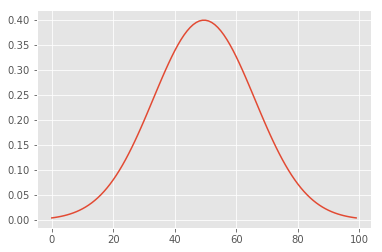

In [7]:
z= gaussian(x=tf.linspace(-3.0, 3.0, 100))
res = z.eval()             ## when call eval(), tensor does the calculation 
plt.plot(res)

now let's do a 2d gaussian 

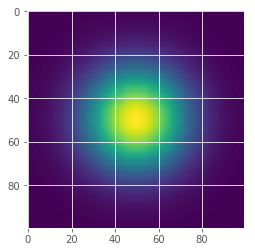

In [8]:
# Let's store the number of values in our Gaussian curve.
ksize = z.get_shape().as_list()[0]   # z is an 1 d array
# Let's multiply the two to get a 2d gaussian
z_2d = tf.matmul(tf.reshape(z, [ksize, 1]), tf.reshape(z, [1, ksize]))
# Execute the graph
plt.imshow(z_2d.eval())

### Convolving an Image with a Gaussian

http://setosa.io/ev/image-kernels/

you can see it as a filter, it averages out a pixel with pixel around it 

(512, 512)


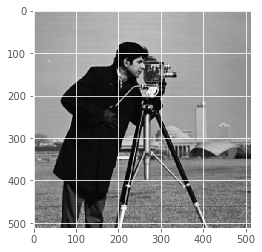

In [12]:
from skimage import data
img = data.camera().astype(np.float32)
plt.imshow(img, cmap='gray')
print(img.shape)

to convolving an image we need to convert it to N x H x W x C

reshape picture into 4 d 

In [13]:
# because our image is a grey image, so it iw 1xHxWx1
# We could use the numpy reshape function to reshape our numpy array
img_4d = img.reshape([1, img.shape[0], img.shape[1], 1])
print(img_4d.shape)

# but since we'll be using tensorflow, we can use the tensorflow reshape function:
img_4d = tf.reshape(img, [1, img.shape[0], img.shape[1], 1])
print(img_4d)
print(img_4d.get_shape().as_list())

(1, 512, 512, 1)
Tensor("Reshape_4:0", shape=(1, 512, 512, 1), dtype=float32)
[1, 512, 512, 1]


#### Appliy the guassian kernal 

shape gaussian kernel into 4d as well. Our Kernel already has a height and width of ksize so we'll stick with that for now. The number of input channels should match the number of channels on the image we want to convolve. And for now, we just keep the same number of output channels as the input channels, but we'll later see how this comes into play.

[100, 100, 1, 1]
(1, 512, 512, 1)


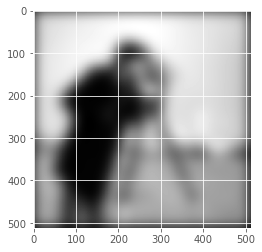

In [14]:
# Reshape the 2d kernel to tensorflow's required 4d format: H x W x I x O
z_4d = tf.reshape(z_2d, [ksize, ksize, 1, 1])
print(z_4d.get_shape().as_list())

## strides is how slider moves, 1,1,1,1 is moving one pixel by pixel
convolved = tf.nn.conv2d(img_4d, z_4d, strides=[1, 1, 1, 1], padding='SAME')
res = convolved.eval()
print(res.shape)

# Or we could specify the exact dimensions we want to visualize:
plt.imshow(res[0, :, :, 0], cmap='gray')

In [ ]:
plt.show()

#### Modulating the Gaussian with a Sine Wave to create Gabor Kernel

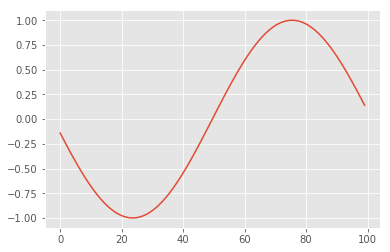

In [15]:
xs = tf.linspace(-3.0, 3.0, ksize)
ys = tf.sin(xs)
plt.figure()
plt.plot(ys.eval())

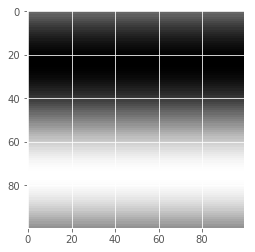

In [16]:
##And for multiplication, we'll need to convert this 1-dimensional vector to a matrix: N x 1
ys = tf.reshape(ys, [ksize, 1])

## if the entire image are all 1s, Sine Wave will result following
ones = tf.ones((1, ksize))
wave = tf.matmul(ys, ones)
plt.imshow(wave.eval(), cmap='gray')

## darker are lower number and lighter are higher numbers 

#### gabor kernel is the dot product of wave and gaussian kernel  

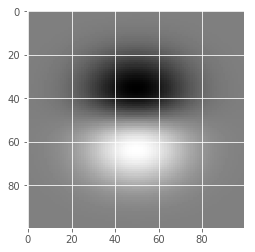

In [14]:
gabor = tf.multiply(wave, z_2d)
plt.imshow(gabor.eval(), cmap='gray')

#### Apply the Gabor kernel - start to end

In [15]:
## make 2d image into 4d 
img = tf.placeholder(tf.float32, shape=[None, None], name='img')
img_3d = tf.expand_dims(img, 2)    ## in the third dimention, make it 1
img_4d = tf.expand_dims(img_3d, 0) ## in the first dimention, make it 1
dims = img_4d.get_shape()
print(dims)

# Let's create another set of placeholders for our Gabor's parameters:
mean = tf.placeholder(tf.float32, name='mean')
sigma = tf.placeholder(tf.float32, name='sigma')
ksize = tf.placeholder(tf.int32, name='ksize')

# Then finally redo the entire set of operations we've done to convolve our
# image, except with our placeholders
x = tf.linspace(-3.0, 3.0, ksize)
z = (tf.exp(tf.negative(tf.pow(x - mean, 2.0) /
                   (2.0 * tf.pow(sigma, 2.0)))) *
      (1.0 / (sigma * tf.sqrt(2.0 * 3.1415))))
z_2d = tf.matmul(
  tf.reshape(z, tf.stack([ksize, 1])),
  tf.reshape(z, tf.stack([1, ksize])))
ys = tf.sin(x)
ys = tf.reshape(ys, tf.stack([ksize, 1]))
ones = tf.ones(tf.stack([1, ksize]))
wave = tf.matmul(ys, ones)
gabor = tf.multiply(wave, z_2d)
gabor_4d = tf.reshape(gabor, tf.stack([ksize, ksize, 1, 1]))

## apply the gabor kernel
convolved = tf.nn.conv2d(img_4d, gabor_4d, strides=[1, 1, 1, 1], padding='SAME', name='convolved')
convolved_img = convolved[0, :, :, 0]

(1, ?, ?, 1)


What we've done is create an entire graph from our placeholders which is capable of convolving an image with a gabor kernel. In order to compute it, we have to specify all of the placeholders required for its computation.

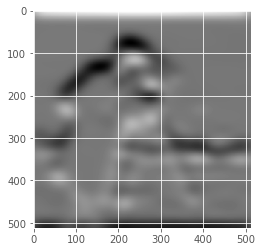

In [16]:
res = convolved_img.eval(feed_dict={
    img: data.camera(), mean:0.0, sigma:1.0, ksize:100})
plt.imshow(res, cmap='gray')

Now, instead of having to rewrite the entire graph, we can just specify the different placeholders.


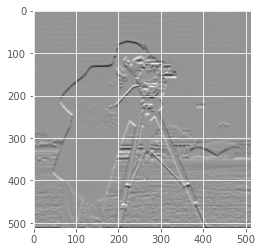

In [21]:
res = convolved_img.eval(feed_dict={
    img: data.camera(),
    mean: 0.0,
    sigma: 0.5,
    ksize: 20
  })
plt.imshow(res, cmap='gray')